Kaggle Dataset: https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data

### IMPORTS

Downloading necessary libraries

In [ ]:
%%capture
!pip install pydrive
!pip install wordcloud
!pip install imblearn
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from tqdm.notebook import tqdm
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    accuracy_score,precision_score,
    recall_score,
    f1_score

)



In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Preprocessing : Kaggle Dataset (Yiğit)


In [ ]:
link = 'https://drive.google.com/file/d/175tkmdRAPL5GOzRf5zG0MAlClFc2qOic/view?usp=drive_link' # The shareable link


In [ ]:
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('text.csv')

df = pd.read_csv('text.csv')
df.head()

Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df.shape

(416809, 2)

In [ ]:
df.duplicated().sum()

686

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['label'] = df['label'].map(emotion_map)

<ipython-input-58-cd587b914311>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(emotion_map)


In [ ]:
df

text     label
0           i just feel really helpless and heavy hearted      fear
1       ive enjoyed being able to slouch about relax a...   sadness
2       i gave up my internship with the dmrg and am f...      fear
3                              i dont know i feel so lost   sadness
4       i am a kindergarten teacher and i am thoroughl...      fear
...                                                   ...       ...
416804  i feel like telling these horny devils to find...      love
416805  i began to realize that when i was feeling agi...     anger
416806  i feel very curious be why previous early dawn...  surprise
416807  i feel that becuase of the tyranical nature of...     anger
416808  i think that after i had spent some time inves...  surprise

[416123 rows x 2 columns]

chat words

In [ ]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The Fuck",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [ ]:
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df['text'] = df['text'].apply(replace_chat_words)

non alpha numeric charachters

In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [ ]:
nltk.download('stopwords')

True

stop words

In [ ]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lowercase

In [ ]:
df['text'] = df['text'].str.lower()

remove numeric

In [ ]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)

remove extra spaces

In [ ]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

remove urls

In [ ]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)

remove empty

In [ ]:
df = df[df['text'] != '']

Word Cloud

In [ ]:
df_sadness = df[df['label']=='sadness']
df_joy = df[df['label']=='joy']
df_love = df[df['label']=='love']
df_anger = df[df['label']=='anger']
df_fear = df[df['label']=='fear']
df_surprise = df[df['label']=='surprise']

combined_sadness_text = ' '.join(df_sadness['text'])
combined_joy_text = ' '.join(df_joy['text'])
combined_love_text = ' '.join(df_love['text'])
combined_anger_text = ' '.join(df_anger['text'])
combined_fear_text = ' '.join(df_fear['text'])
combined_surprise_text = ' '.join(df_surprise['text'])

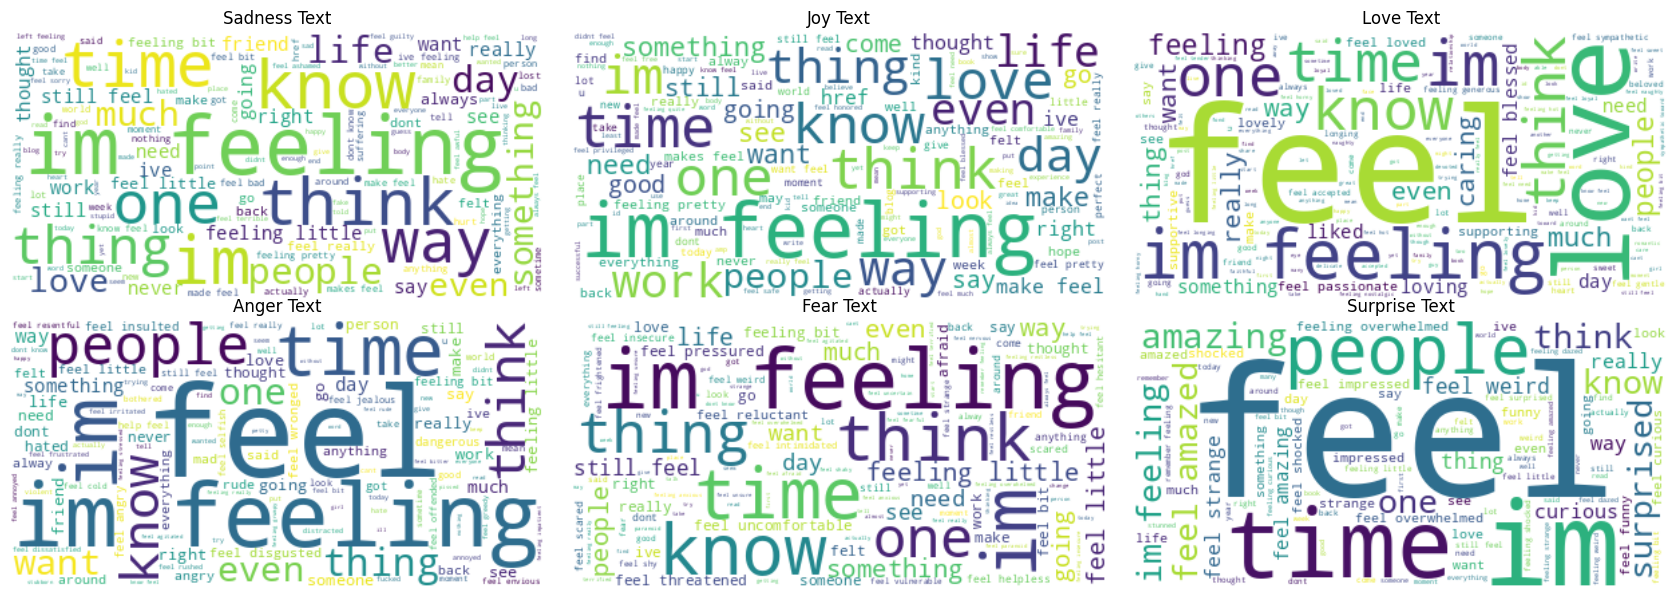

In [ ]:
wordclouds = {
    "Sadness": WordCloud(width=400, height=200, background_color='white').generate(combined_sadness_text),
    "Joy": WordCloud(width=400, height=200, background_color='white').generate(combined_joy_text),
    "Love": WordCloud(width=400, height=200, background_color='white').generate(combined_love_text),
    "Anger": WordCloud(width=400, height=200, background_color='white').generate(combined_anger_text),
    "Fear": WordCloud(width=400, height=200, background_color='white').generate(combined_fear_text),
    "Surprise": WordCloud(width=400, height=200, background_color='white').generate(combined_surprise_text)
}

plt.figure(figsize=(17, 6))

for i, (emotion, wordcloud) in enumerate(wordclouds.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{emotion} Text')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
nltk.download('punkt')

True

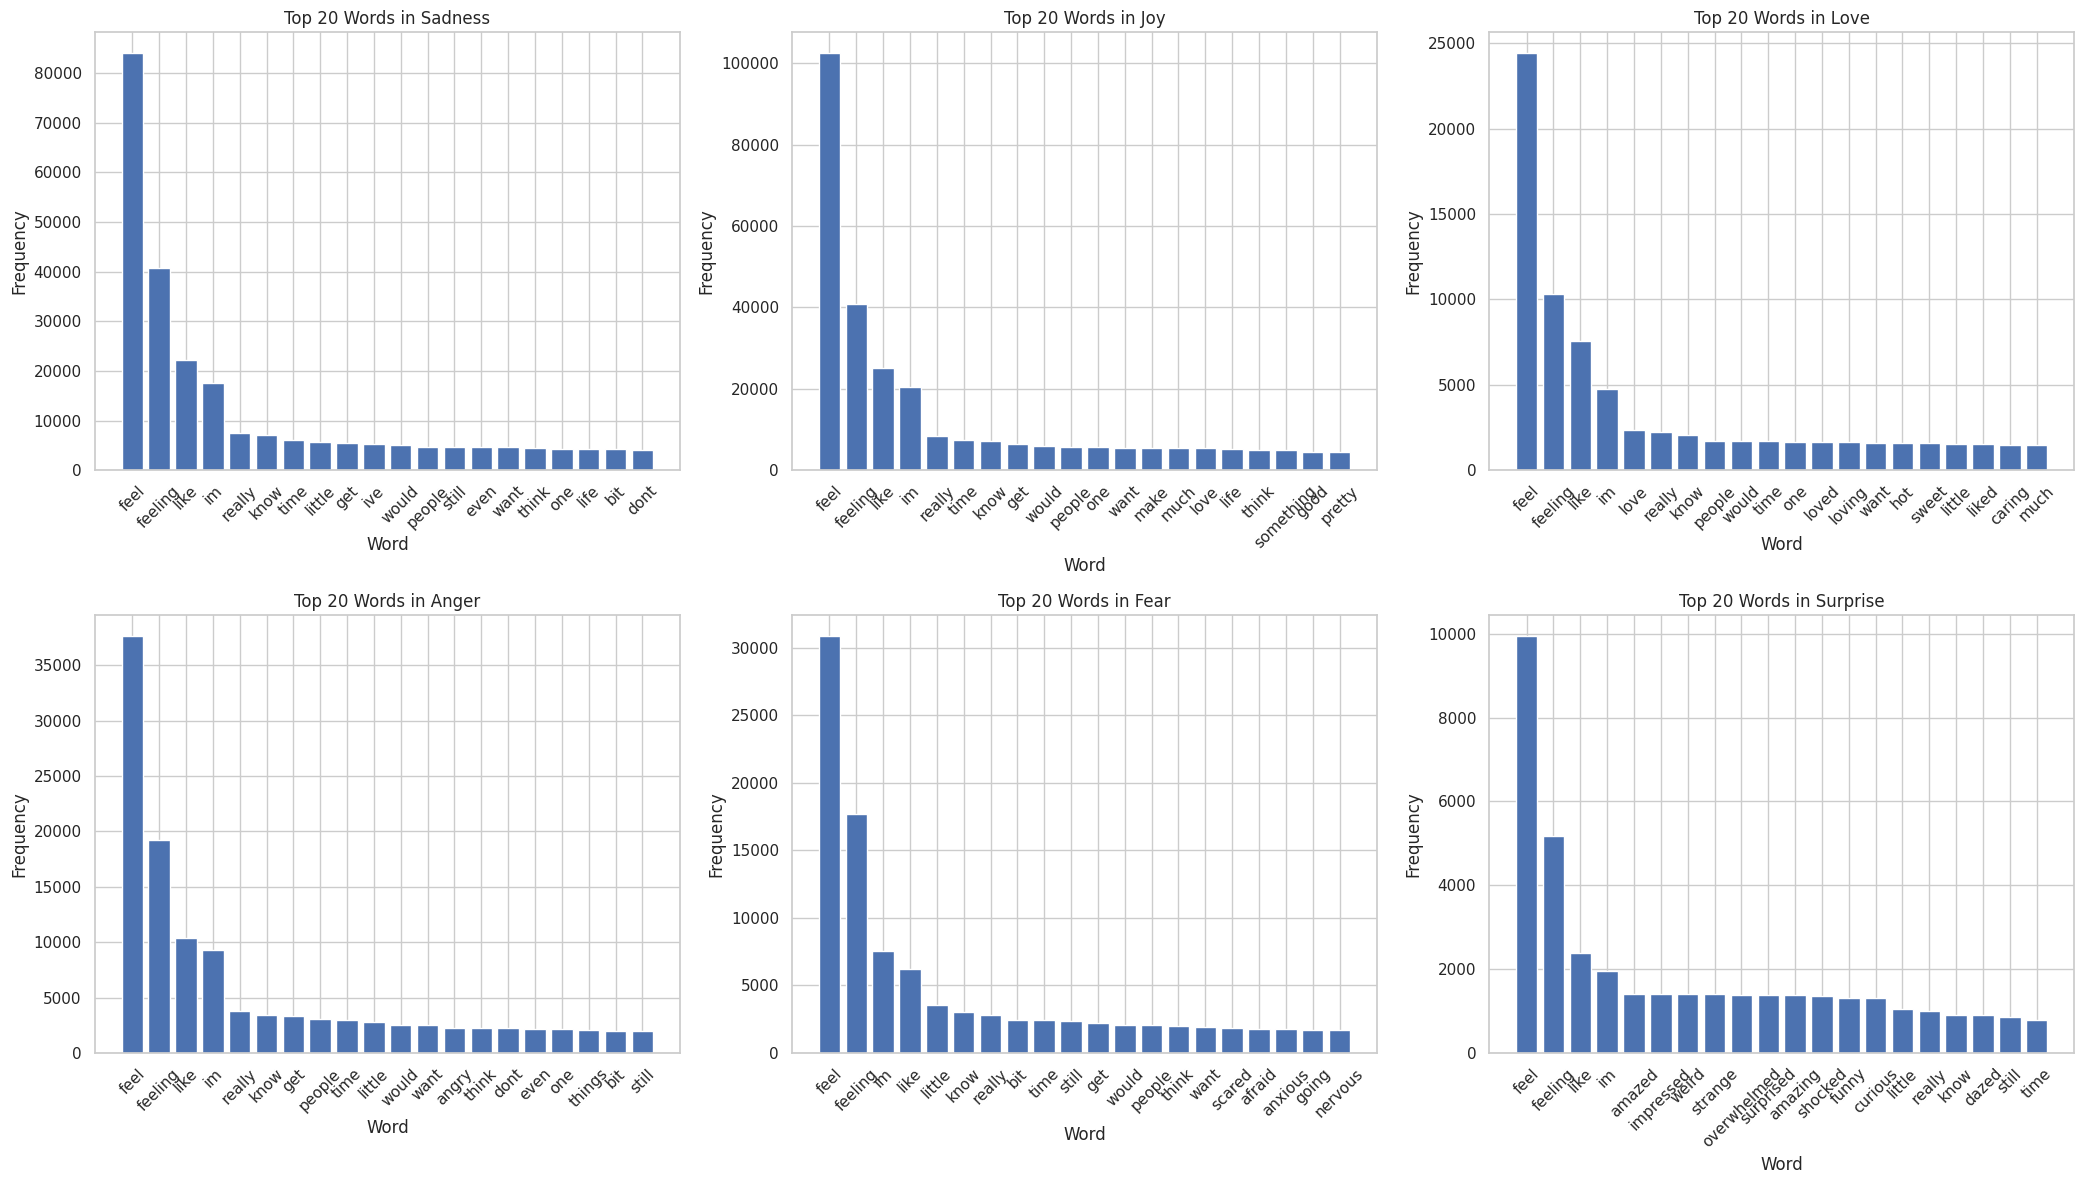

In [ ]:
top_20_words_emotions = {}
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

for emotion in emotions:
    emotion_texts = df[df['label'] == emotion]['text']
    words = [word.lower() for text in emotion_texts for word in word_tokenize(text)]
    word_freq = Counter(words)
    top_20_words_emotions[emotion] = dict(word_freq.most_common(20))

# Set up subplots
fig, axs = plt.subplots(2, 3, figsize=(21, 12))

# Plot bar charts for each emotion
for i, (emotion, top_words) in enumerate(top_20_words_emotions.items()):
    ax = axs[i // 3, i % 3]
    ax.bar(top_words.keys(), top_words.values())
    ax.set_title(f"Top 20 Words in {emotion.capitalize()}")
    ax.set_xlabel("Word")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-72-95e9c200fa1a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.values, y=count.index, ax=axs[0], palette=palette)


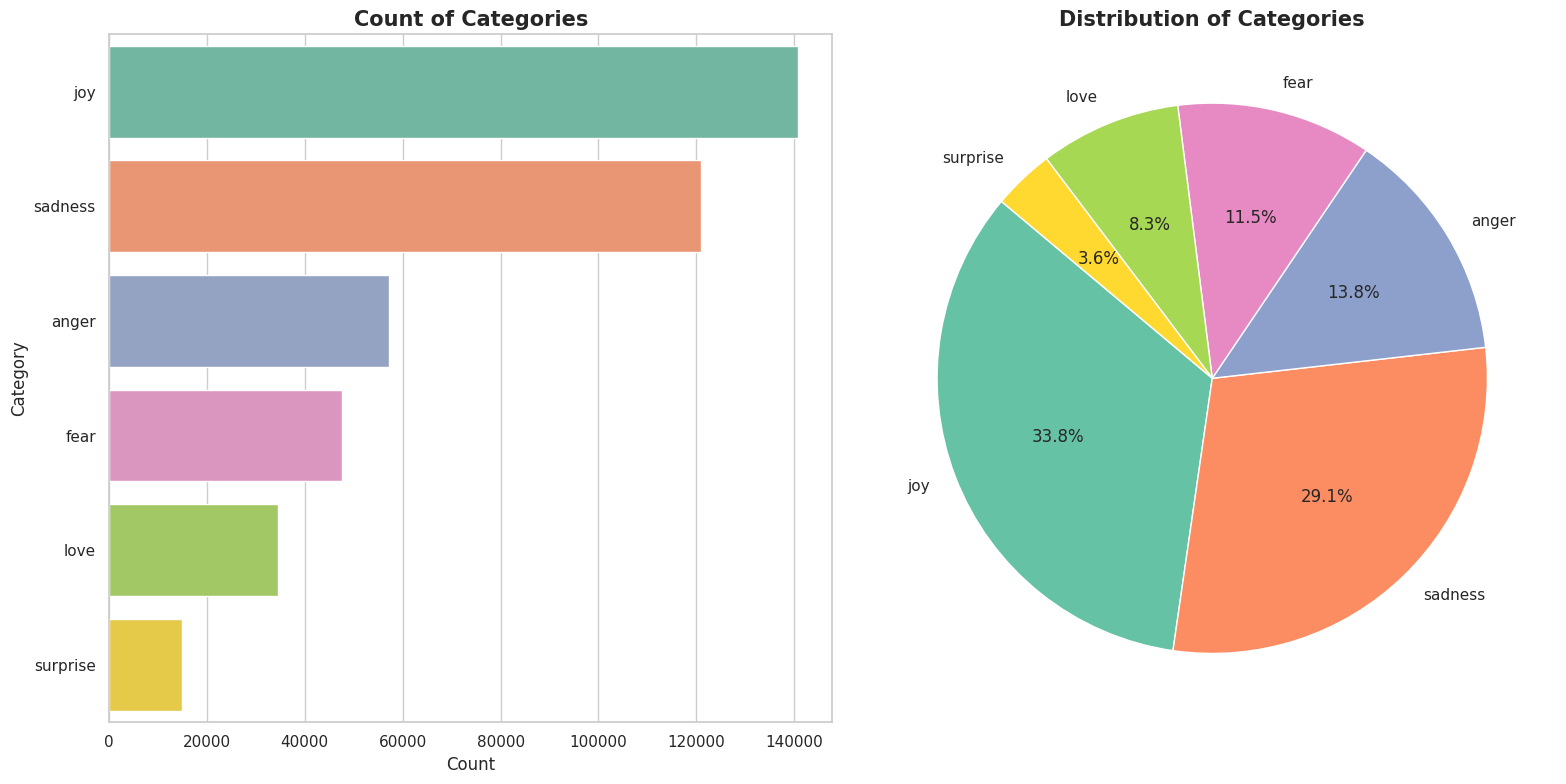

In [ ]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = 'white'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor=background_color)

# Plot horizontal bar chart on the first subplot
palette = sns.color_palette("Set2", len(count))
sns.barplot(x=count.values, y=count.index, ax=axs[0], palette=palette)
axs[0].set_title('Count of Categories', fontsize=15, fontweight='bold')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Category')

# Plot pie chart on the second subplot
axs[1].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[1].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Oversampling with SMOTE (cannot be implemented)

In [ ]:
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTETomek
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# X_tfidf = vectorizer.fit_transform(df['text'])

In [ ]:
# # Define your target labels
# target_counts = df['label'].value_counts()
# majority_classes = target_counts.index[:4].tolist()  # Get the top 2 majority classes
# minority_classes = target_counts.index[4:].tolist() # Get the rest

# # Subsample majority classes
# df_majority = df[df['label'].isin(majority_classes)]
# df_minority = df[df['label'].isin(minority_classes)]

# df_majority_undersampled = df_majority.sample(n=35000, random_state=1) # Adjust sample size as needed

# # Get the indices of the minority class samples in df
# minority_indices = df[df['label'].isin(minority_classes)].index

# valid_indices = [index for index in minority_indices if index < X_tfidf.shape[0]]  # Filter out invalid indices

# # Oversample minority classes using SMOTE with reduced k_neighbors
# smote = SMOTE(k_neighbors=3, random_state=1)
# X_smote, y_smote = smote.fit_resample(X_tfidf[valid_indices], df.loc[valid_indices, 'label'])

# # Combine SMOTE results with undersampled majority
# oversample = SMOTETomek(smote=smote)
# X_oversampled, y_oversampled = oversample.fit_resample(X_tfidf[valid_indices], df.loc[valid_indices, 'label'])

# # Combine oversampled minority with undersampled majority
# df_balanced = pd.concat([df_majority_undersampled, pd.DataFrame(X_oversampled, columns=X_tfidf.columns), pd.DataFrame(y_oversampled, columns=['label'])])

Undersampling to handle class imbalances

In [ ]:
print("Number of 'surprise' values:", df[df['label'] == 'surprise'].shape[0])


Number of 'surprise' values: 14959


In [ ]:
def stratify_data(df, length=None):
    if length is not None and length > df.shape[0]:
        raise ValueError("Length parameter cannot be greater than the size of the dataset.")
    length = length if length is not None else len(df)

    min_count = df['label'].value_counts().min()
    df_stratified = df.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
    df_stratified = df_stratified.sample(length)

    return df_stratified

df1 = stratify_data(df, 89700)

In [ ]:
df1.label.value_counts()

label
surprise    14953
sadness     14952
joy         14952
love        14951
anger       14948
fear        14944
Name: count, dtype: int64

In [ ]:
df2 = stratify_data(df, 1000)

Make the dataset smaller but keep the imbalances at the same ratio (for BERT)

In [ ]:
new_counts = (df['label'].value_counts() / 4).astype(int) #take the quarter of each class

reduced_df = pd.DataFrame()  # create a new data frame for the reduced version
for label, sample_count in new_counts.items():
  cur_label = df[label == df['label']]
  if len(cur_label) >= sample_count:
    cur_label = cur_label.sample(n=sample_count, random_state=35)
  reduced_df = pd.concat([reduced_df, cur_label], axis=0)


In [ ]:
reduced_df.label.value_counts() #our new , reduced, dataset

label
joy         35194
sadness     30246
anger       14307
fear        11915
love         8624
surprise     3739
Name: count, dtype: int64

<ipython-input-77-cbeeb8582e84>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.values, y=count.index, ax=axs[0], palette=palette)


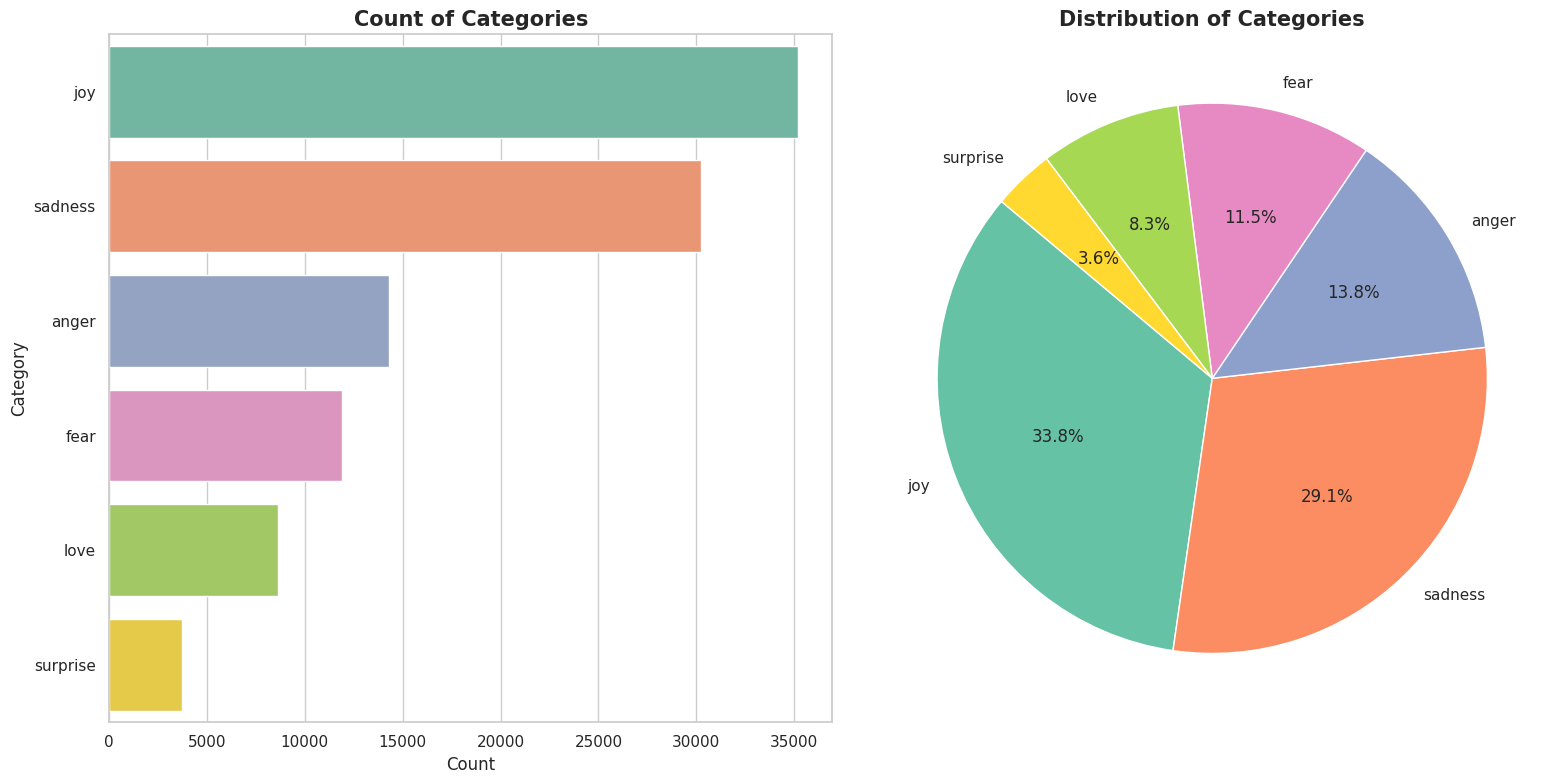

In [ ]:
# Value count of 'label'
count = reduced_df['label'].value_counts()

# Set the background color and theme
background_color = 'white'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor=background_color)

# Plot horizontal bar chart on the first subplot
palette = sns.color_palette("Set2", len(count))
sns.barplot(x=count.values, y=count.index, ax=axs[0], palette=palette)
axs[0].set_title('Count of Categories', fontsize=15, fontweight='bold')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Category')

# Plot pie chart on the second subplot
axs[1].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[1].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Naive Bayes (Berna & Ali)


For alpha=0.001 and max_features=2000, accuracy is: 0.8763
For alpha=0.001 and max_features=3000, accuracy is: 0.8648
For alpha=0.001 and max_features=4000, accuracy is: 0.8443
For alpha=0.001 and max_features=5000, accuracy is: 0.8217
For alpha=0.001 and max_features=6000, accuracy is: 0.8009
For alpha=0.01 and max_features=2000, accuracy is: 0.8764
For alpha=0.01 and max_features=3000, accuracy is: 0.8651
For alpha=0.01 and max_features=4000, accuracy is: 0.8463
For alpha=0.01 and max_features=5000, accuracy is: 0.8260
For alpha=0.01 and max_features=6000, accuracy is: 0.8075
For alpha=0.1 and max_features=2000, accuracy is: 0.8771
For alpha=0.1 and max_features=3000, accuracy is: 0.8694
For alpha=0.1 and max_features=4000, accuracy is: 0.8564
For alpha=0.1 and max_features=5000, accuracy is: 0.8440
For alpha=0.1 and max_features=6000, accuracy is: 0.8343
For alpha=1 and max_features=2000, accuracy is: 0.8819
For alpha=1 and max_features=3000, accuracy is: 0.8816
For alpha=1 and max_

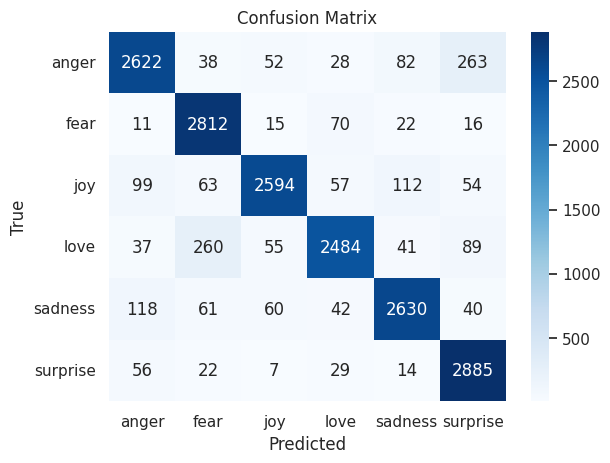

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df1['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df1['emotion_number'] = df1['label'].map(label_to_int)

# Splitting the Data into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(df1['text'], df1['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
alpha_vals = [10 ** k for k in range(-3, 3)]
max_features_vals = [2000, 3000, 4000, 5000, 6000]

for alpha in alpha_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = MultinomialNB(alpha=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For alpha={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

print(best_alpha)
print(best_max_features)

best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['anger','fear','joy','love','sadness','surprise']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Logistic Regression w/ imbalanced data

In [ ]:
unique_labels = df['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df['emotion_number'] = df['label'].map(label_to_int)

# Splitting the Data into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
alpha_vals = [10 ** k for k in range(-3, 3)]
max_features_vals = [2000, 3000, 4000, 5000, 6000]

for alpha in alpha_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = MultinomialNB(alpha=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For alpha={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

print(best_alpha)
print(best_max_features)

best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['anger','fear','joy','love','sadness','surprise']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<ipython-input-26-02cb60f7cdeb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emotion_number'] = df['label'].map(label_to_int)


KeyboardInterrupt: 

# Logistic Regression (Yiğit)

For C=0.1 and max_features=3000, accuracy is: 0.9052
For C=0.1 and max_features=4000, accuracy is: 0.9052
For C=0.1 and max_features=5000, accuracy is: 0.9048
For C=1 and max_features=3000, accuracy is: 0.9074
For C=1 and max_features=4000, accuracy is: 0.9090
For C=1 and max_features=5000, accuracy is: 0.9084
For C=10 and max_features=3000, accuracy is: 0.8953
For C=10 and max_features=4000, accuracy is: 0.8941
For C=10 and max_features=5000, accuracy is: 0.8928
For C=100 and max_features=3000, accuracy is: 0.8720
For C=100 and max_features=4000, accuracy is: 0.8679
For C=100 and max_features=5000, accuracy is: 0.8647
1
4000
classification_report: 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3085
           1       0.90      0.95      0.92      2946
           2       0.94      0.90      0.92      2979
           3       0.92      0.88      0.90      2966
           4       0.91      0.92      0.91      2951
           5    

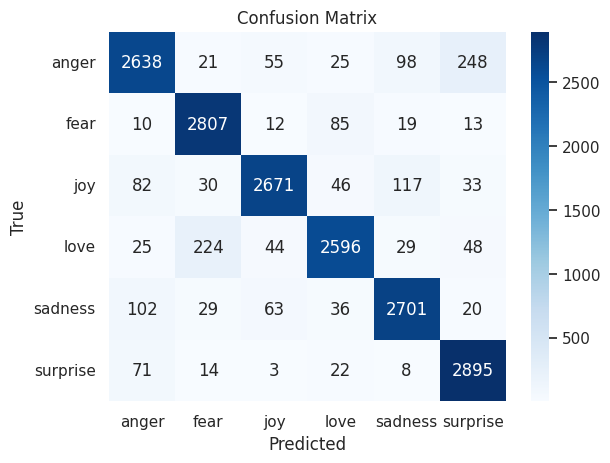

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df1['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df1['emotion_number'] = df1['label'].map(label_to_int)

X_train, X_test, y_train, y_test = train_test_split(df1['text'], df1['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
C_vals = [10 ** k for k in range(-1, 3)]
max_features_vals = [3000, 4000, 5000]

for alpha in C_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = LogisticRegression(max_iter=3000, C=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For C={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

best_model = LogisticRegression(max_iter=3000, C=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

print(best_alpha)
print(best_max_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['anger','fear','joy','love','sadness','surprise']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### BERT Implementation

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModel
from scipy.special import softmax

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch

# BERT (İdil)

### Implementing Emotion Detection along with Neural Networks

In [ ]:
class EmotionDetector(nn.Module):
  def __init__(self, model, class_range, kernel_size=3, out_channels=256):
        super(EmotionDetector, self).__init__() #initilize the model
        self.transformer = model #set the transformer model
        #use CNN to filter and extarct the important features
        self.conv = nn.Conv1d(in_channels=768, out_channels=out_channels, kernel_size=kernel_size, padding=1)
        #use FNN to transform the output from CNN to a final prediction
        self.fc = nn.Linear(out_channels, class_range)

  def forward(self, input_ids, attention_mask):
    output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
    lhd = output.last_hidden_state  # get the last hidden state from the output
    CLS_token = lhd[:, 0, :]  # extract the CLS token from the last hidden state
    CLS_token = CLS_token.unsqueeze(2)

    CNN_output = F.relu(self.conv(CLS_token)) #apply non-linearity to get the complex relations
    pooled_CNN, _ = torch.max(CNN_output, dim=2) #get the pooled output from CNN

    result = self.fc(pooled_CNN) #get the actual result from FNN layer
    return result

### Focal Loss: implementation in https://paperswithcode.com/method/focal-loss is used

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()



In [ ]:

def compute_weights(labels):
  total = sum(labels.values())


  #calcuşate the weights, şnversed -> if it is a frequent class, we will have lower weighy


  inverse_frequencies = []

  #calculate the inverse frequency for each class
  for frequency in labels.values():
    inverse_frequencies.append(total / frequency)


  #compute the total weight
  total_weight = sum(inverse_frequencies)


  fl_weights = []

  #scale the focal loss weights for each class with the total_weight
  for frequency in (inverse_frequencies):
    fl_weights.append( frequency / total_weight )

  return fl_weights


### Initialize necessary bert models and functions

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
def preprare_model(df, bert_tokenizer, bert_model):
  df['label'] = label_encoder.fit_transform(df['label'])

  # split into train and validation
  t_tweets, v_tweets, t_emotions, v_emotions = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

  # tokenize and encode for train test
  t_encoding = bert_tokenizer(t_tweets.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

  # tokenize and encode for validation set
  v_encoding = bert_tokenizer(v_tweets.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')


  # convert input id's into torch tensors for both train and validation encodings
  t_sequence = torch.tensor(t_encoding['input_ids'])
  v_sequence = torch.tensor(v_encoding['input_ids'])


  # convert attention masks into torch tensors to ignore padding in processing
  v_masks = torch.tensor(v_encoding['attention_mask'])
  t_masks = torch.tensor(t_encoding['attention_mask'])



  #conver the data into tensor form
  train_tensor = torch.utils.data.TensorDataset(t_sequence, t_masks, torch.tensor(np.array(t_emotions),dtype=torch.float64))
  validation_tensor = torch.utils.data.TensorDataset(v_sequence, v_masks, torch.tensor(np.array(v_emotions),dtype=torch.float64), )

  train_DL = DataLoader(train_tensor, batch_size=32, shuffle=True, num_workers=4)

  validation_DL = DataLoader(validation_tensor, batch_size=32)

  return train_DL,validation_DL




In [ ]:
def train_model(train_DL, model, loss_fn, optimizer, epochs, device):
    model.train()
    total_loss = 0
    for epoch in range(epochs):

        with tqdm(total=len(train_DL) //100, desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar: #progress bar
            for i, batch in enumerate(train_DL):
                input_ids, attention_mask, labels = batch #got the current input ids with attention mask

                #transfer everything into the device
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device).long()

                #actual training
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                total_loss += loss
                loss.backward()
                optimizer.step()

                # Progress bar to not give up on training
                if (i + 1) % 100 == 0 or i == len(train_DL) - 1:
                    pbar.update(1)

    return total_loss


This was used to optimize the learning rate

In [ ]:
def objective(trial):
    #initlize the device, model and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EmotionDetector(bert_model, class_range=6).to(device)
    loss_fn = torch.nn.CrossEntropyLoss().to(device)

    #define the learning rate range
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)

    #set the learning rate to the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # find out the best learning rate
    return train_model(train_DL, model, loss_fn, optimizer, 3, device)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def predict_and_measure(model, test_dataset):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in test_dataset:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device).long()

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")


    labels=['anger','fear','joy','love','sadness','surprise']
    cf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


### TRAINING WITH THE df1 with Cross Entropy

In [ ]:
train_DL , validation_DL = preprare_model(df1, bert_tokenizer, bert_model)

NameError: name 'bert_tokenizer' is not defined

In [ ]:
emotion_detector_model = EmotionDetector(bert_model, class_range=6)

In [ ]:
adam_optimizer = torch.optim.Adam(emotion_detector_model.parameters(), lr=1.19e-06)

loss_function = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_detector_model.to(device)

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
emotion_detector_model.train()

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Call your training function with appropriate parameters
train_loss = train_model(train_DL, emotion_detector_model, loss_function, adam_optimizer, 3, device)

Epoch 1/3:   0%|          | 0/25 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/3:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 3/3:   0%|          | 0/25 [00:00<?, ?batch/s]

In [ ]:
train_loss

1.5640945867238492

Validation Accuracy: 0.9507246376811594
Precision: 0.9518026608146325
Recall: 0.9507246376811594
F1 Score: 0.9505598737494949


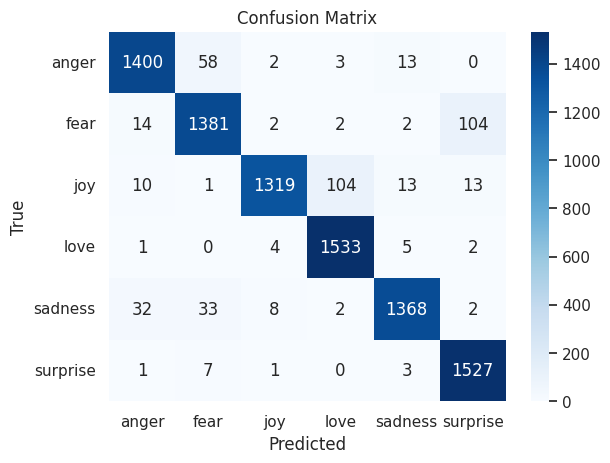

In [ ]:
predict_and_measure(emotion_detector_model, validation_DL)

### Traning with df1 but using Focal Loss as the loss function

In [ ]:
emotions = {
    'joy': 35194,
    'sadness': 30246,
    'anger': 14307,
    'fear': 11915,
    'love': 8624,
    'surprise': 3739
}

weights = compute_weights(emotions)

focal_loss = FocalLoss(alpha=weights, gamma=2.0)

In [ ]:
emotion_detector_model1 = EmotionDetector(bert_model, class_range=6)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
emotion_detector_model1.to(device)

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
focal_loss

FocalLoss()

In [ ]:
weights

[0.04745887057788129,
 0.055222756434502224,
 0.11674477466400741,
 0.1401819128088925,
 0.19367665713334348,
 0.44671502838137317]

In [ ]:
adam_optimizer = torch.optim.Adam(emotion_detector_model1.parameters(), lr=1.19e-06)

In [ ]:
train_model(train_DL, emotion_detector_model1, focal_loss, adam_optimizer, 3, device)

Validation Accuracy: 0.9453734671125975
Precision: 0.9487128132448561
Recall: 0.9453734671125975
F1 Score: 0.9447261044806236


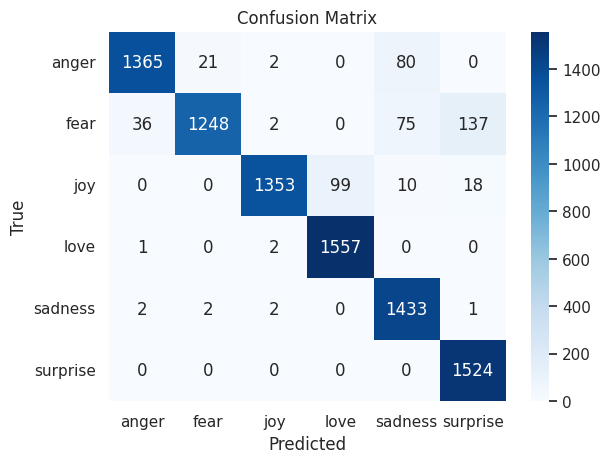

In [ ]:
predict_and_measure(emotion_detector_model1, validation_DL)

### TRAINING WITH REDUCED BUT STILL IMBALANCED DATA SET w/ Cross Entropy


In [ ]:
train_DL2,validation_DL2 =  preprare_model(reduced_df, bert_tokenizer, bert_model)

In [ ]:
emotion_detector_model2 = EmotionDetector(bert_model, class_range=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_detector_model2.to(device)

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
adam_optimizer2 = torch.optim.Adam(emotion_detector_model2.parameters(), lr=1.19e-06)
loss_function2 = nn.CrossEntropyLoss()

In [ ]:
emotion_detector_model2.train()

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
train_model(train_DL2, emotion_detector_model2, loss_function2, adam_optimizer2, 3, device)

Epoch 1/3:   0%|          | 0/29 [00:00<?, ?batch/s]

Epoch 2/3:   0%|          | 0/29 [00:00<?, ?batch/s]

Epoch 3/3:   0%|          | 0/29 [00:00<?, ?batch/s]

0.7564786382051986

Validation Accuracy: 0.9373257714120926
Precision: 0.9392401408294929
Recall: 0.9373257714120926
F1 Score: 0.93707873759212


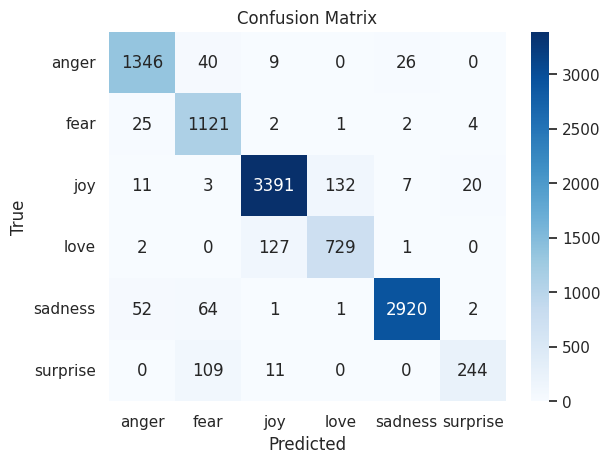

In [ ]:
predict_and_measure(emotion_detector_model2, validation_DL2)

### TRYING roBERTa

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch
# Initialize tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

In [ ]:
train_DL5,validation_DL5 = preprare_model(reduced_df,roberta_tokenizer, roberta_tokenizer)


<ipython-input-85-19a9eab869c9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-85-19a9eab869c9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-85-19a9eab869c9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_masks = torch.tensor(v_encoding['attention_mask'])
<ipython-input-85-19a9eab869c9>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

In [ ]:

emotion_detector_model5 = EmotionDetector(roberta_model, class_range=6)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotion_detector_model5.to(device)


EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:

adam_optimizer5 = torch.optim.Adam(emotion_detector_model5.parameters(), lr=1e-5)
loss_function5 = nn.CrossEntropyLoss()

In [ ]:

emotion_detector_model5.train()

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:

train_model(train_DL5, emotion_detector_model5, loss_function5, adam_optimizer5, 1, device)

Epoch 1/1:   0%|          | 0/29 [00:00<?, ?batch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(837.9952, device='cuda:0', grad_fn=<AddBackward0>)

Validation Accuracy: 0.9391521676439488
Precision: 0.939356309776076
Recall: 0.9391521676439488
F1 Score: 0.9381515479509244


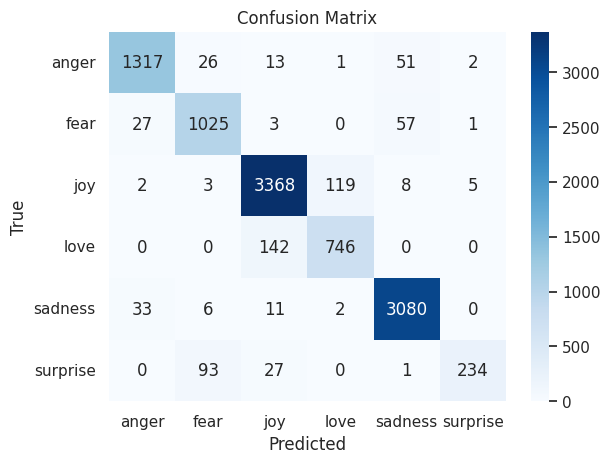

In [ ]:

predict_and_measure(emotion_detector_model5, validation_DL5)

### TRAINING WITH REDUCED BUT STILL IMBALANCED DATA SET w/ Focal Loss


In [ ]:
emotions = {
    'joy': 35194,
    'sadness': 30246,
    'anger': 14307,
    'fear': 11915,
    'love': 8624,
    'surprise': 3739
}

weights2 = compute_weights(emotions)


focal_loss2 = FocalLoss(alpha=weights2, gamma=2.0)

In [ ]:
train_model(train_DL2, emotion_detector_model2, focal_loss2, adam_optimizer2, 3, device)

Epoch 1/3:   0%|          | 0/29 [00:00<?, ?batch/s]

Epoch 2/3:   0%|          | 0/29 [00:00<?, ?batch/s]

Epoch 3/3:   0%|          | 0/29 [00:00<?, ?batch/s]

0.012672845466395808

Validation Accuracy: 0.9362683841199654
Precision: 0.9395552160119194
Recall: 0.9362683841199654
F1 Score: 0.9357349448406601


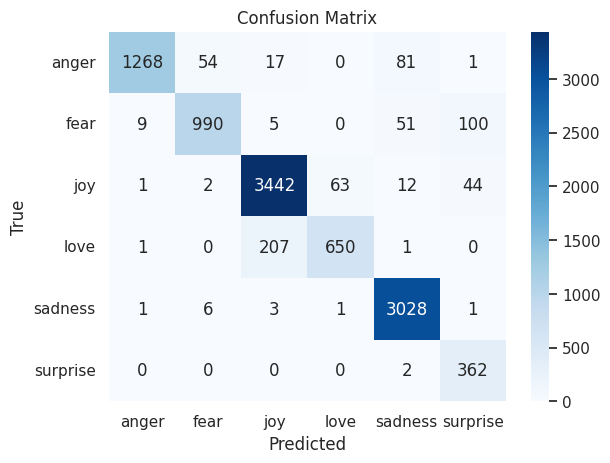

In [ ]:
predict_and_measure(emotion_detector_model2, validation_DL2)

### TRYING roBERTa w/ Cross entropy

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch
# Initialize tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
train_DL5,validation_DL5 = preprare_model(reduced_df,roberta_tokenizer, roberta_tokenizer)


<ipython-input-40-f8dc000f6f46>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-40-f8dc000f6f46>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-40-f8dc000f6f46>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_masks = torch.tensor(v_encoding['attention_mask'])
<ipython-input-40-f8dc000f6f46>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

In [ ]:

emotion_detector_model5 = EmotionDetector(roberta_model, class_range=6)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotion_detector_model5.to(device)


EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:

adam_optimizer5 = torch.optim.Adam(emotion_detector_model5.parameters(), lr=1e-5)
loss_function5 = nn.CrossEntropyLoss()

In [ ]:

emotion_detector_model5.train()

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:

train_model(train_DL5, emotion_detector_model5, loss_function5, adam_optimizer5, 1, device)

Epoch 1/1:   0%|          | 0/29 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Accuracy: 0.9355955012977026
Precision: 0.9414844663343758
Recall: 0.9355955012977026
F1 Score: 0.9364201203730493


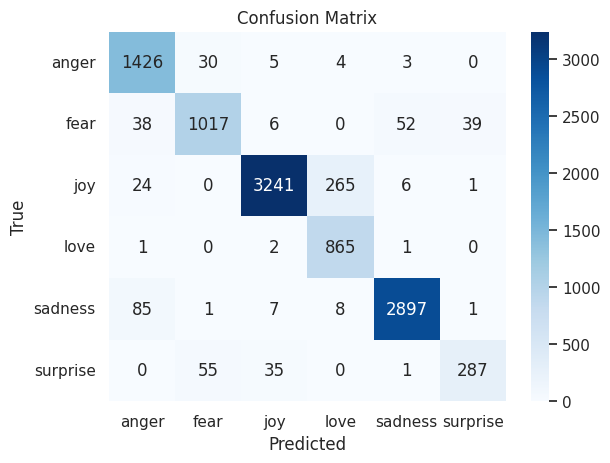

In [ ]:

predict_and_measure(emotion_detector_model5, validation_DL5)

### TRYING roBERTa w/ Focal Loss

In [ ]:
train_DL6,validation_DL6 = preprare_model(reduced_df,roberta_tokenizer, roberta_tokenizer)


<ipython-input-40-f8dc000f6f46>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-40-f8dc000f6f46>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-40-f8dc000f6f46>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_masks = torch.tensor(v_encoding['attention_mask'])
<ipython-input-40-f8dc000f6f46>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

In [ ]:

emotion_detector_model6 = EmotionDetector(roberta_model, class_range=6)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotion_detector_model6.to(device)


EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:

adam_optimizer6 = torch.optim.Adam(emotion_detector_model6.parameters(), lr=1e-5)
focal_loss6 = FocalLoss(alpha=weights2, gamma=2.0)

In [ ]:

emotion_detector_model6.train()

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:

train_model(train_DL6, emotion_detector_model6, focal_loss6, adam_optimizer6, 1, device)


Epoch 1/1:   0%|          | 0/29 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Accuracy: 0.9361722580024993
Precision: 0.9472882176214603
Recall: 0.9361722580024993
F1 Score: 0.9378344075180085


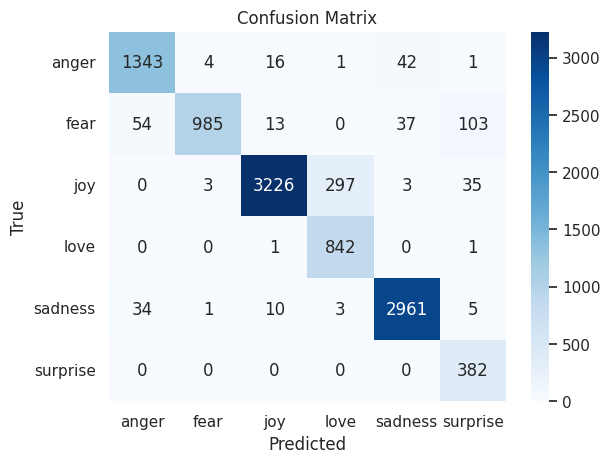

In [ ]:
predict_and_measure(emotion_detector_model6, validation_DL6)

# Trying a different dataset : SemEval (Göktuğ)


### Preprocess

In [ ]:
link = 'https://drive.google.com/file/d/1xMtvAGAask2ZAewHPnoqSQ9Jn6CKZF_b/view?usp=drivesdk'
import re
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('total.txt')

data = []
i = 1
with open('total.txt', 'r') as file:
    for line in file:
        line = line.strip()
        parts = line.split('\t')
        i+=1
        sequence = parts[0]
        label = parts[1]
        text = '\t'.join(parts[2:])
        text = re.sub(r'@\w+', '', text)
        data.append(( sequence,label, text))

df_new = pd.DataFrame(data, columns=[ 'sequence','label', 'text'])
df_new.head()

sequence     label  \
0  260097528899452929   neutral   
1  263791921753882624   neutral   
2  264194578381410304  negative   
3  264041328420204544   neutral   
4  263816256640126976   neutral   

                                                text  
0  Won the match #getin . Plus\u002c tomorrow is ...  
1  Some areas of New England could see the first ...  
2   2nd worst QB. DEFINITELY Tony Romo. The man w...  
3  #Thailand Washington - US President Barack Oba...  
4  Did y\u2019all hear what Tony Romo dressed up ...

In [ ]:
df_new.duplicated().sum()

645

In [ ]:
df_new = df_new.drop_duplicates()
df_new.shape

(49603, 3)

In [ ]:
df_new.drop_duplicates(subset='sequence', inplace=True)
df_new = df_new.drop('sequence', axis=1)

unique_labels = df_new['label'].unique()
print(unique_labels)

df_new.shape

['neutral' 'negative' 'positive']


(49484, 2)

In [ ]:
df_new.isnull().sum()


label    0
text     0
dtype: int64

In [ ]:
df_new['text'] = df_new['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [ ]:
nltk.download('stopwords')

True

In [ ]:
stop = stopwords.words('english')
df_new["text"] = df_new['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df_new['text'] = df_new['text'].str.lower()
df_new['text'] = df_new['text'].str.replace(r'\d+', '', regex=True)
df_new['text'] = df_new['text'].str.replace(r'\s+', ' ', regex=True)
df_new['text'] = df_new['text'].str.replace(r'http\S+', '', regex=True)
df_new = df_new[df_new['text'] != '']

<ipython-input-19-c6ed536fc381>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.values, y=count.index, ax=axs[0], palette=palette)


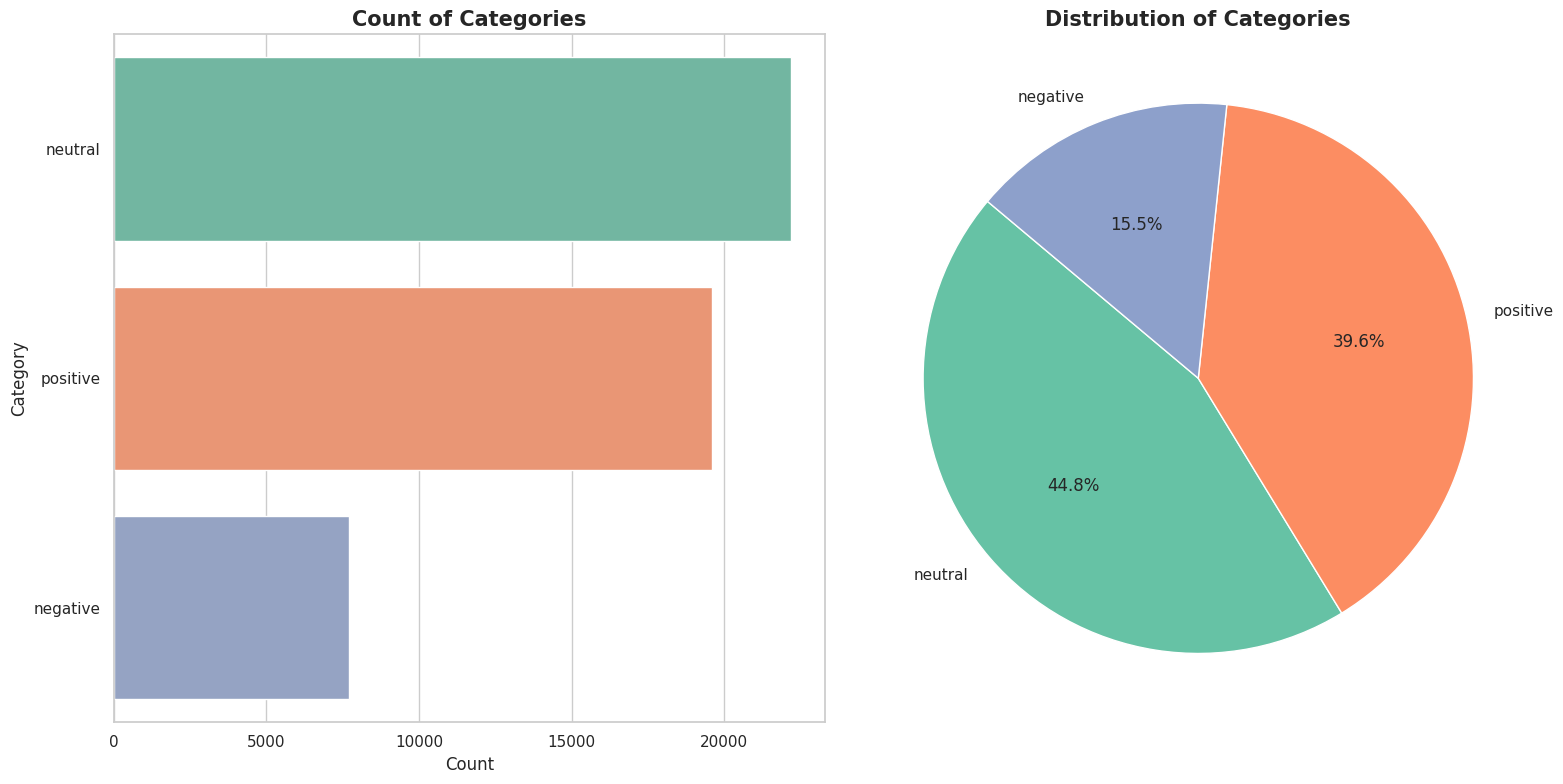

In [ ]:
# Value count of 'label'
count = df_new['label'].value_counts()

# Set the background color and theme
background_color = 'white'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8), facecolor=background_color)

# Plot horizontal bar chart on the first subplot
palette = sns.color_palette("Set2", len(count))
sns.barplot(x=count.values, y=count.index, ax=axs[0], palette=palette)
axs[0].set_title('Count of Categories', fontsize=15, fontweight='bold')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Category')

# Plot pie chart on the second subplot
axs[1].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[1].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Word cloud

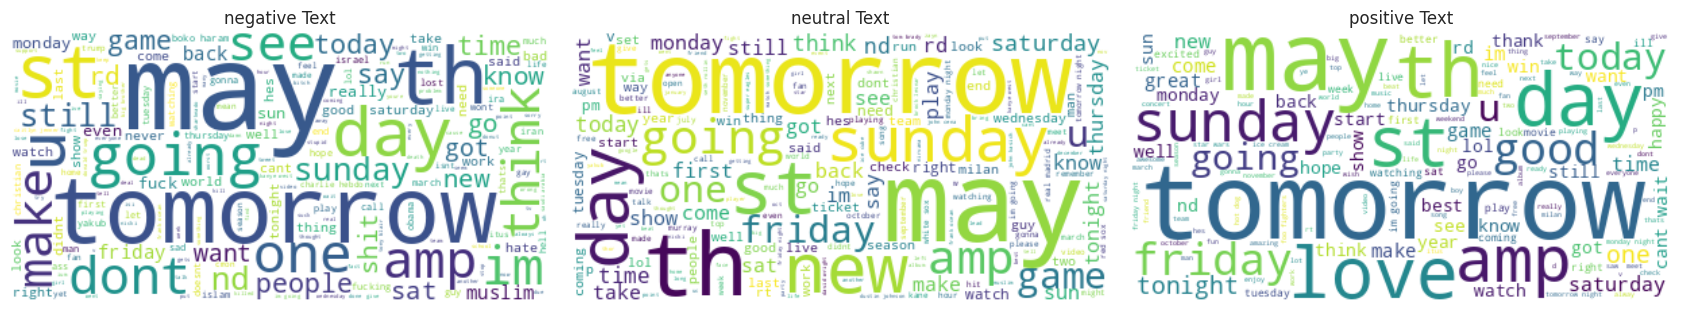

In [ ]:
df_new_negative = df_new[df_new['label']=='negative']
df_new_neutral = df_new[df_new['label']=='neutral']
df_new_positive = df_new[df_new['label']=='positive']

combined_negative_text = ' '.join(df_new_negative['text'])
combined_neutral_text = ' '.join(df_new_neutral['text'])
combined_positive_text = ' '.join(df_new_positive['text'])

wordclouds = {
    "negative": WordCloud(width=400, height=200, background_color='white').generate(combined_negative_text),
    "neutral": WordCloud(width=400, height=200, background_color='white').generate(combined_neutral_text),
    "positive": WordCloud(width=400, height=200, background_color='white').generate(combined_positive_text),
    }

plt.figure(figsize=(17, 6))

for i, (emotion, wordcloud) in enumerate(wordclouds.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{emotion} Text')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df_new.label.value_counts()

label
neutral     22188
positive    19603
negative     7692
Name: count, dtype: int64

In [ ]:
df_new['label']

0         neutral
1         neutral
2        negative
3         neutral
4         neutral
           ...   
50243    positive
50244     neutral
50245     neutral
50246    positive
50247     neutral
Name: label, Length: 49483, dtype: object

In [ ]:
df_new

label                                               text
0       neutral  won match getin plusuc tomorrow busy dayuc awa...
1       neutral  some areas new england could see first flakes ...
2      negative  nd worst qb definitely tony romo the man likes...
3       neutral  thailand washington us president barack obama ...
4       neutral  did yuall hear tony romo dressed halloween a g...
...         ...                                                ...
50243  positive  ok good know punting metlife december task hop...
50244   neutral  everyone sat around metlife annoying didnt let...
50245   neutral  giants niners fans would wanna go sunday night...
50246  positive  anybody want ticket tomorrow colombia vs peru ...
50247   neutral  mendez told hed drive metlife sunday my reaction 

[49483 rows x 2 columns]

In [ ]:
df_two_labels = df_new[df_new['label'] != 'neutral']
df_two_labels.label.value_counts()

label
positive    19603
negative     7692
Name: count, dtype: int64

### Naive Bayes

In [ ]:
df_new

label                                               text
0       neutral  won match getin plusuc tomorrow busy dayuc awa...
1       neutral  some areas new england could see first flakes ...
2      negative  nd worst qb definitely tony romo the man likes...
3       neutral  thailand washington us president barack obama ...
4       neutral  did yuall hear tony romo dressed halloween a g...
...         ...                                                ...
50243  positive  ok good know punting metlife december task hop...
50244   neutral  everyone sat around metlife annoying didnt let...
50245   neutral  giants niners fans would wanna go sunday night...
50246  positive  anybody want ticket tomorrow colombia vs peru ...
50247   neutral  mendez told hed drive metlife sunday my reaction 

[49483 rows x 2 columns]

For alpha=0.001 and max_features=2000, accuracy is: 0.6023
For alpha=0.001 and max_features=3000, accuracy is: 0.6067
For alpha=0.001 and max_features=4000, accuracy is: 0.6052
For alpha=0.001 and max_features=5000, accuracy is: 0.6054
For alpha=0.001 and max_features=6000, accuracy is: 0.6018
For alpha=0.01 and max_features=2000, accuracy is: 0.6023
For alpha=0.01 and max_features=3000, accuracy is: 0.6069
For alpha=0.01 and max_features=4000, accuracy is: 0.6050
For alpha=0.01 and max_features=5000, accuracy is: 0.6057
For alpha=0.01 and max_features=6000, accuracy is: 0.6021
For alpha=0.1 and max_features=2000, accuracy is: 0.6018
For alpha=0.1 and max_features=3000, accuracy is: 0.6076
For alpha=0.1 and max_features=4000, accuracy is: 0.6062
For alpha=0.1 and max_features=5000, accuracy is: 0.6086
For alpha=0.1 and max_features=6000, accuracy is: 0.6038
For alpha=1 and max_features=2000, accuracy is: 0.5998
For alpha=1 and max_features=3000, accuracy is: 0.6084
For alpha=1 and max_

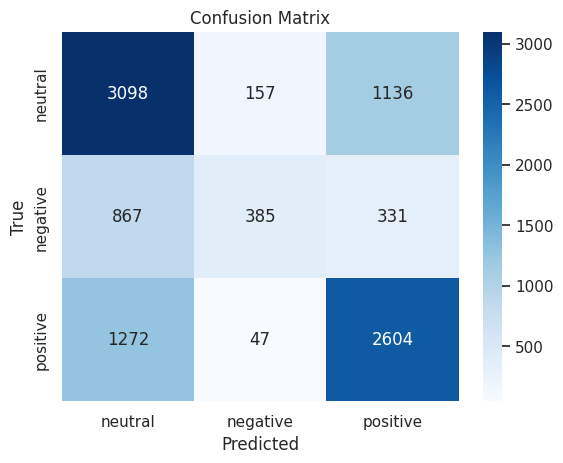

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df_new['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df_new['emotion_number'] = df_new['label'].map(label_to_int)

# Splitting the Data into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
alpha_vals = [10 ** k for k in range(-3, 3)]
max_features_vals = [2000, 3000, 4000, 5000, 6000]

for alpha in alpha_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = MultinomialNB(alpha=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For alpha={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

print(best_alpha)
print(best_max_features)

best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['neutral','negative','positive']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Logistic Regression

For C=0.1 and max_features=3000, accuracy is: 0.6073
For C=0.1 and max_features=4000, accuracy is: 0.6045
For C=0.1 and max_features=5000, accuracy is: 0.6043
For C=1 and max_features=3000, accuracy is: 0.6311
For C=1 and max_features=4000, accuracy is: 0.6307
For C=1 and max_features=5000, accuracy is: 0.6349
For C=10 and max_features=3000, accuracy is: 0.6218
For C=10 and max_features=4000, accuracy is: 0.6154
For C=10 and max_features=5000, accuracy is: 0.6182
For C=100 and max_features=3000, accuracy is: 0.6158
For C=100 and max_features=4000, accuracy is: 0.6056
For C=100 and max_features=5000, accuracy is: 0.6012
1
5000
classification_report: 
               precision    recall  f1-score   support

           0       0.61      0.75      0.67      4391
           1       0.64      0.33      0.44      1583
           2       0.69      0.65      0.67      3923

    accuracy                           0.64      9897
   macro avg       0.65      0.58      0.59      9897
weighted avg   

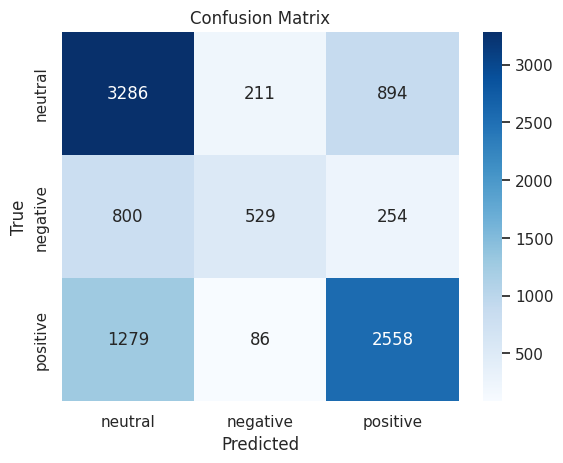

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df_new['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df_new['emotion_number'] = df_new['label'].map(label_to_int)

X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
C_vals = [10 ** k for k in range(-1, 3)]
max_features_vals = [3000, 4000, 5000]

for alpha in C_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = LogisticRegression(max_iter=3000, C=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For C={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

best_model = LogisticRegression(max_iter=3000, C=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

print(best_alpha)
print(best_max_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['neutral','negative','positive']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Multinomial Logistic Regression (Softmax Regression)

For C=0.1 and max_features=3000, accuracy is: 0.6073
For C=0.1 and max_features=4000, accuracy is: 0.6045
For C=0.1 and max_features=5000, accuracy is: 0.6045
For C=1 and max_features=3000, accuracy is: 0.6311
For C=1 and max_features=4000, accuracy is: 0.6305
For C=1 and max_features=5000, accuracy is: 0.6348
For C=10 and max_features=3000, accuracy is: 0.6218
For C=10 and max_features=4000, accuracy is: 0.6157
For C=10 and max_features=5000, accuracy is: 0.6184
For C=100 and max_features=3000, accuracy is: 0.6156
For C=100 and max_features=4000, accuracy is: 0.6057
For C=100 and max_features=5000, accuracy is: 0.6012
1
5000
classification_report: 
               precision    recall  f1-score   support

           0       0.61      0.75      0.67      4391
           1       0.64      0.33      0.44      1583
           2       0.69      0.65      0.67      3923

    accuracy                           0.64      9897
   macro avg       0.65      0.58      0.59      9897
weighted avg   

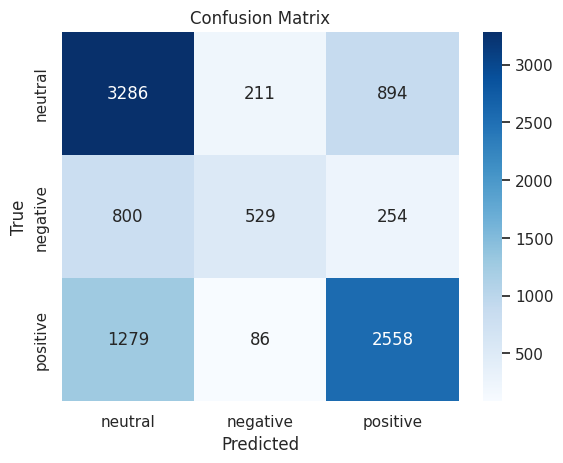

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df_new['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df_new['emotion_number'] = df_new['label'].map(label_to_int)

X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
C_vals = [10 ** k for k in range(-1, 3)]
max_features_vals = [3000, 4000, 5000]

for alpha in C_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = LogisticRegression(max_iter=3000, multi_class='multinomial', C=alpha, solver='sag')
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For C={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

best_model = LogisticRegression(max_iter=3000, C=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

print(best_alpha)
print(best_max_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['neutral','negative','positive']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### BERT with Cross Entropy

In [ ]:
train_DL3,validation_DL3 =  preprare_model(df_two_labels, bert_tokenizer, bert_model)

<ipython-input-8-19a9eab869c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['label'])
<ipython-input-8-19a9eab869c9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-8-19a9eab869c9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-8-19a9eab869c9>:20: UserWarning: To co

In [ ]:
emotion_detector_model3 = EmotionDetector(bert_model, class_range=3)

In [ ]:
adam_optimizer3 = torch.optim.Adam(emotion_detector_model3.parameters(), lr=5e-5)

loss_function3 = nn.CrossEntropyLoss()

In [ ]:
emotion_detector_model3 = EmotionDetector(bert_model, class_range=2)

In [ ]:
train_DL3

In [ ]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_detector_model3.to(device2)

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
emotion_detector_model3.train()

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL3, emotion_detector_model3, loss_function3, adam_optimizer3, 2, device2)

Epoch 1/2:   0%|          | 0/7 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2:   0%|          | 0/7 [00:00<?, ?batch/s]

tensor(112.8542, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
def check_missclasifications(all_labels, all_preds):
  data = {'Actual': all_labels, 'Predicted': all_preds}
  df = pd.DataFrame(data)

  df['Is_Correct'] = df['Actual'] == df['Predicted']

  # filter the dataset to get the ones with misclassifications only
  misclassified = df[df['Is_Correct'] == False]

  # Display the first few rows of the misclassified examples
  print(misclassified.head())

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def predict_and_measure2(model, test_dataset, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in test_dataset:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device).long()

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    #check_missclasifications(all_labels, all_preds)
    labels=['negative','positive']
    cf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Validation Accuracy: 0.9805860805860805
Precision: 0.9805785696181101
Recall: 0.9805860805860805
F1 Score: 0.9805821629478552
     Actual  Predicted  Is_Correct
3         1          0       False
93        0          1       False
176       0          1       False
226       1          0       False
318       0          1       False


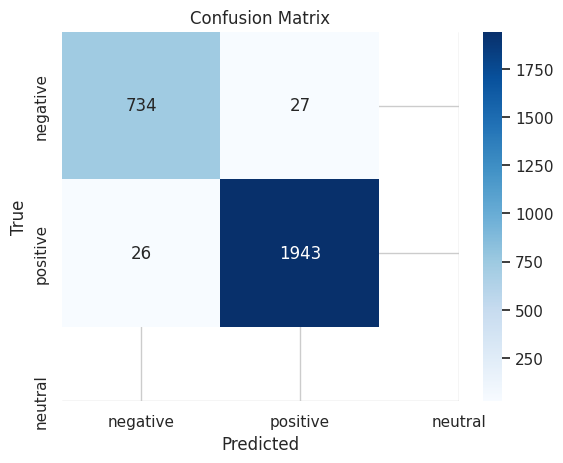

In [ ]:
predict_and_measure2(emotion_detector_model3, validation_DL3, device2)

### BERT w/ Focal Loss

Calculate inverse weights

In [ ]:

emotions2 = {
    'neutral': 22188,
    'positive': 19603,
    'negative': 7692
}

weights = compute_weights(emotions2)


In [ ]:
weights

[0.19934523250301603, 0.22563240416145083, 0.575022363335533]

In [ ]:
alpha = [0.75, 1, 1.5]

In [ ]:
focal_loss = FocalLoss(alpha=torch.tensor(alpha, device=device2), gamma=1.5)

In [ ]:
emotion_detector_model4 = EmotionDetector(bert_model, class_range=3)

In [ ]:
adam_optimizer3 = torch.optim.Adam(emotion_detector_model4.parameters(), lr=5e-5)


In [ ]:
emotion_detector_model4.to(device2)

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
emotion_detector_model4.train()

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL3, emotion_detector_model4, focal_loss, adam_optimizer3, 1, device2)

Epoch 1/1:   0%|          | 0/13 [00:00<?, ?batch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-54-e8dc7b712a75>:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork()

tensor(44.3380, device='cuda:0', grad_fn=<AddBackward0>)

Validation Accuracy: 0.6944837340876945
Precision: 0.6932786148411351
Recall: 0.6944837340876945
F1 Score: 0.6920168935506926
    Actual  Predicted  Is_Correct
1        1          2       False
6        2          1       False
7        2          1       False
8        0          2       False
20       1          0       False


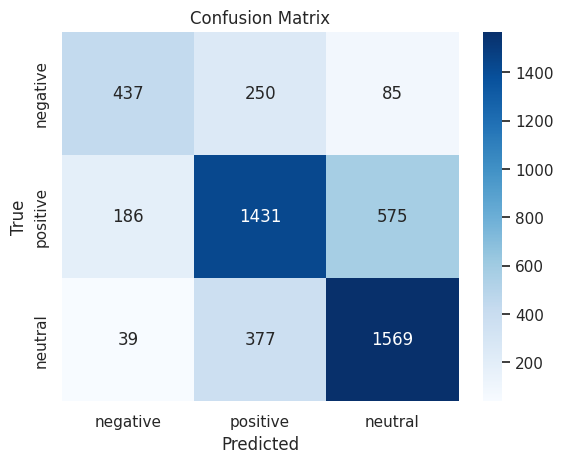

In [ ]:
predict_and_measure2(emotion_detector_model4, validation_DL3, device2) # alpha = 0.75, 1, 1.5 gamma = 2.0

### roBERTa with Cross Entropy

In [ ]:
train_DL3,validation_DL3 =  preprare_model(df_new, roberta_tokenizer, roberta_model)

<ipython-input-8-19a9eab869c9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-8-19a9eab869c9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-8-19a9eab869c9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_masks = torch.tensor(v_encoding['attention_mask'])
<ipython-input-8-19a9eab869c9>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [ ]:
emotion_detector_model3 = EmotionDetector(roberta_model, class_range=3)

In [ ]:
adam_optimizer3 = torch.optim.Adam(emotion_detector_model3.parameters(), lr=5e-5)
loss_function3 = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_detector_model3.to(device)

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
emotion_detector_model3.train()

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL3, emotion_detector_model3, loss_function3, adam_optimizer3, 3, device2)

Epoch 1/3:   0%|          | 0/13 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/3:   0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3/3:   0%|          | 0/13 [00:00<?, ?batch/s]

Validation Accuracy: 0.7005455647605577
Precision: 0.7006077183792051
Recall: 0.7005455647605577
F1 Score: 0.6984307166121579


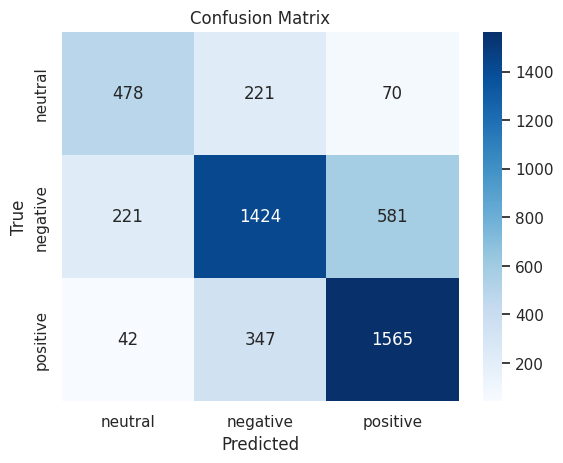

In [ ]:
predict_and_measure2(emotion_detector_model3, validation_DL3,,device2)

### roBERTa w/ Focal Loss

In [ ]:

emotions2 = {
    'neutral': 22188,
    'negative': 19603,
    'positive': 7692
}

weights = compute_weights(emotions2)

focal_loss2 = FocalLoss(alpha=weights, gamma=2.0)

In [ ]:
alpha = [0.75, 1, 1.5]

In [ ]:
focal_loss = FocalLoss(alpha=torch.tensor(alpha, device=device2), gamma=1.5)

In [ ]:
weights

[0.19934523250301603, 0.22563240416145083, 0.575022363335533]

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL3, emotion_detector_model3, focal_loss, adam_optimizer3, 4, device2)

Epoch 1/4:   0%|          | 0/13 [00:00<?, ?batch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-e8dc7b712a75>:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


Epoch 2/4:   0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3/4:   0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4/4:   0%|          | 0/13 [00:00<?, ?batch/s]

tensor(1859.9785, device='cuda:0', grad_fn=<AddBackward0>)

Validation Accuracy: 0.692261062840978
Precision: 0.6920376262012828
Recall: 0.692261062840978
F1 Score: 0.6894770465452517
    Actual  Predicted  Is_Correct
1        1          2       False
6        2          1       False
7        2          1       False
11       1          2       False
24       2          1       False


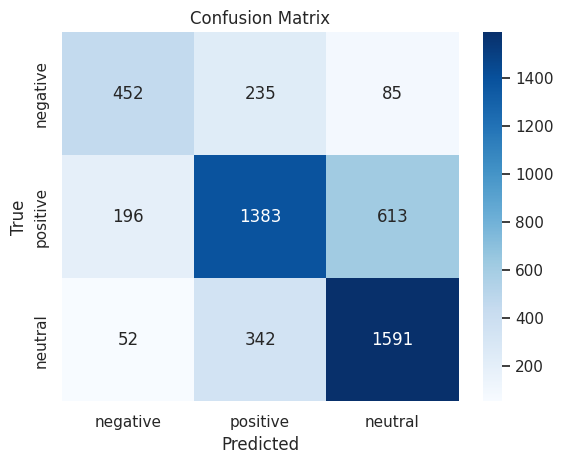

In [ ]:
predict_and_measure2(emotion_detector_model3, validation_DL3, device2)

# Trying Binary SemEval


### BERT with Cross Entropy

In [ ]:
train_DL4,validation_DL4 =  preprare_model(df_two_labels, bert_tokenizer, bert_model)

<ipython-input-8-19a9eab869c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['label'])
<ipython-input-8-19a9eab869c9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-8-19a9eab869c9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-8-19a9eab869c9>:20: UserWarning: To co

In [ ]:
emotion_detector_model4 = EmotionDetector(bert_model, class_range=2)

In [ ]:
adam_optimizer3 = torch.optim.Adam(emotion_detector_model4.parameters(), lr=5e-5)

loss_function4 = nn.CrossEntropyLoss()

In [ ]:
train_DL4

In [ ]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_detector_model4.to(device2)

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
emotion_detector_model4.train()

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL4, emotion_detector_model4, loss_function4, adam_optimizer3, 1, device2)

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(19.7161, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def predict_and_measure3(model, test_dataset, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in test_dataset:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device).long()

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    labels=['negative','positive']
    cf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Validation Accuracy: 0.8765567765567766
Precision: 0.8742176580697045
Recall: 0.8765567765567766
F1 Score: 0.8747471593064087


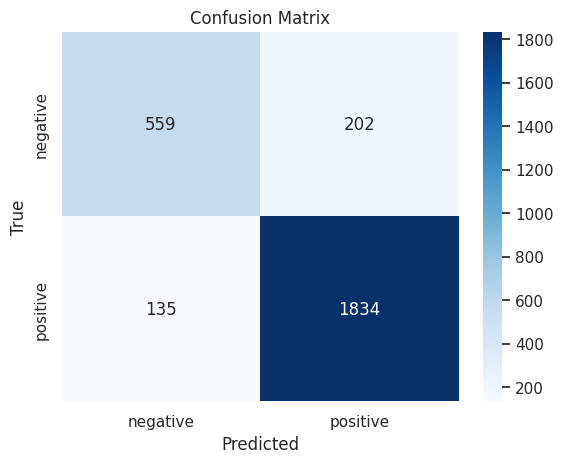

In [ ]:
predict_and_measure3(emotion_detector_model4, validation_DL4, device2)

### BERT w/ Focal Loss

### Naive Bayes

### Logistic Regression

<ipython-input-115-2929e16fc672>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_labels['emotion_number'] = df_two_labels['label'].map(label_to_int)


For C=0.1 and max_features=3000, accuracy is: 0.7523
For C=0.1 and max_features=4000, accuracy is: 0.7496
For C=0.1 and max_features=5000, accuracy is: 0.7463
For C=1 and max_features=3000, accuracy is: 0.8357
For C=1 and max_features=4000, accuracy is: 0.8350
For C=1 and max_features=5000, accuracy is: 0.8353
For C=10 and max_features=3000, accuracy is: 0.8362
For C=10 and max_features=4000, accuracy is: 0.8317
For C=10 and max_features=5000, accuracy is: 0.8370
For C=100 and max_features=3000, accuracy is: 0.8186
For C=100 and max_features=4000, accuracy is: 0.8095
For C=100 and max_features=5000, accuracy is: 0.8122
10
5000
classification_report: 
               precision    recall  f1-score   support

           0       0.75      0.63      0.69      1579
           1       0.86      0.92      0.89      3880

    accuracy                           0.83      5459
   macro avg       0.81      0.77      0.79      5459
weighted avg       0.83      0.83      0.83      5459



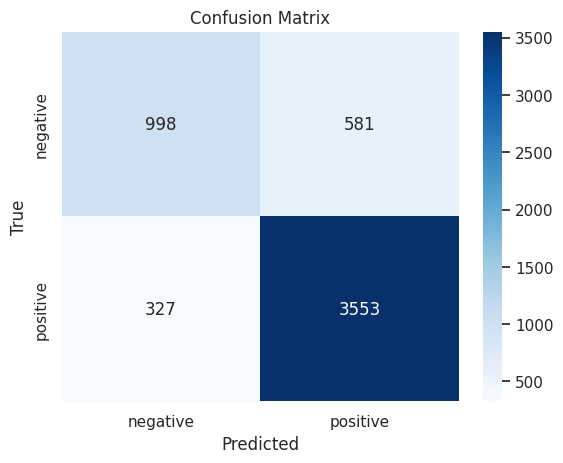

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df_two_labels['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df_two_labels['emotion_number'] = df_two_labels['label'].map(label_to_int)

X_train, X_test, y_train, y_test = train_test_split(df_two_labels['text'], df_two_labels['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
C_vals = [10 ** k for k in range(-1, 3)]
max_features_vals = [3000, 4000, 5000]

for alpha in C_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = LogisticRegression(max_iter=3000, C=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For C={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

best_model = LogisticRegression(max_iter=3000, C=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

print(best_alpha)
print(best_max_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['negative','positive']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Multinomial Logistic Regression (Softmax Regression)

For C=0.1 and max_features=3000, accuracy is: 0.6073
For C=0.1 and max_features=4000, accuracy is: 0.6045
For C=0.1 and max_features=5000, accuracy is: 0.6045
For C=1 and max_features=3000, accuracy is: 0.6311
For C=1 and max_features=4000, accuracy is: 0.6305
For C=1 and max_features=5000, accuracy is: 0.6348
For C=10 and max_features=3000, accuracy is: 0.6218
For C=10 and max_features=4000, accuracy is: 0.6157
For C=10 and max_features=5000, accuracy is: 0.6184
For C=100 and max_features=3000, accuracy is: 0.6156
For C=100 and max_features=4000, accuracy is: 0.6057
For C=100 and max_features=5000, accuracy is: 0.6012
1
5000
classification_report: 
               precision    recall  f1-score   support

           0       0.61      0.75      0.67      4391
           1       0.64      0.33      0.44      1583
           2       0.69      0.65      0.67      3923

    accuracy                           0.64      9897
   macro avg       0.65      0.58      0.59      9897
weighted avg   

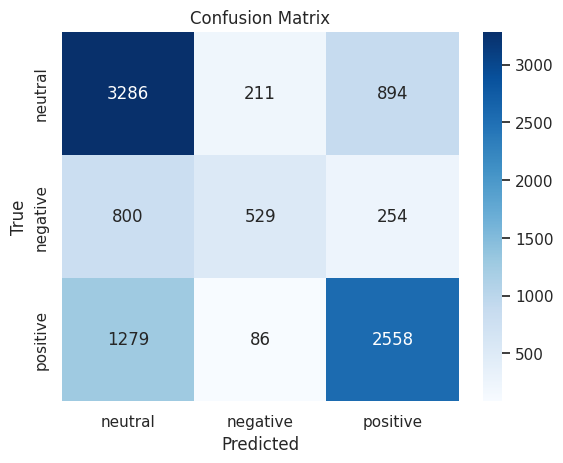

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df_two_labels['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df_two_labels['emotion_number'] = df_two_labels['label'].map(label_to_int)

X_train, X_test, y_train, y_test = train_test_split(df_two_labels['text'], df_two_labels['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
C_vals = [10 ** k for k in range(-1, 3)]
max_features_vals = [3000, 4000, 5000]

for alpha in C_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = LogisticRegression(max_iter=3000, multi_class='multinomial', C=alpha, solver='sag')
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For C={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

best_model = LogisticRegression(max_iter=3000, C=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

print(best_alpha)
print(best_max_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['neutral','negative','positive']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### roBERTa

In [ ]:
train_DL3,validation_DL3 =  preprare_model(df_two_labels, roberta_tokenizer, roberta_model)

<ipython-input-7-19a9eab869c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['label'])
<ipython-input-7-19a9eab869c9>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_sequence = torch.tensor(t_encoding['input_ids'])
<ipython-input-7-19a9eab869c9>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_sequence = torch.tensor(v_encoding['input_ids'])
<ipython-input-7-19a9eab869c9>:20: UserWarning: To co

In [ ]:
emotion_detector_model3 = EmotionDetector(roberta_model, class_range=2)

In [ ]:
adam_optimizer3 = torch.optim.Adam(emotion_detector_model3.parameters(), lr=5e-5)
loss_function3 = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_detector_model3.to(device)

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
emotion_detector_model3.train()

EmotionDetector(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL3, emotion_detector_model3, loss_function3, adam_optimizer3, 1, device2)

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?batch/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(454.0294, device='cuda:0', grad_fn=<AddBackward0>)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 0.7212454212454212
Precision: 0.5201949576674851
Recall: 0.7212454212454212
F1 Score: 0.6044401934165713


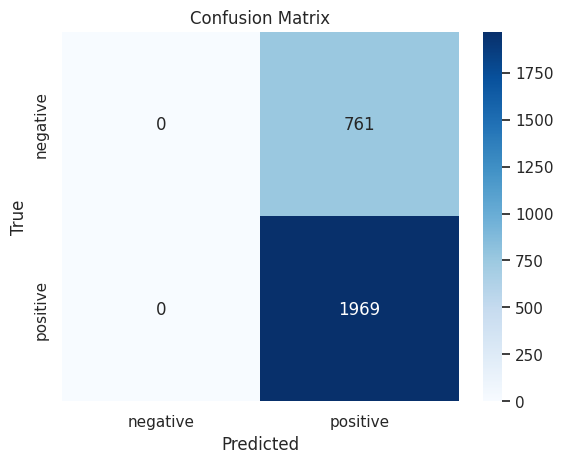

In [ ]:
predict_and_measure2(emotion_detector_model3, validation_DL3, device)

In [ ]:
df_two_labels.label.value_counts()

label
1    19603
0     7692
Name: count, dtype: int64

In [ ]:

emotions2 = {
    'positive': 19603,
    'negative': 7692
}

weights = compute_weights(emotions2)


In [ ]:
weights

[0.2818098552848507, 0.7181901447151493]

In [ ]:
alpha = [1.1, 3.5]

In [ ]:
focal_loss = FocalLoss(alpha=torch.tensor(weights, device=device2), gamma=1.5)

In [ ]:
emotion_detector_model4 = EmotionDetector(bert_model, class_range=2)

In [ ]:
adam_optimizer3 = torch.optim.Adam(emotion_detector_model4.parameters(), lr=2e-5)


In [ ]:
emotion_detector_model4.to(device2)

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
emotion_detector_model4.train()

EmotionDetector(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Call your training function with appropriate parameters
train_model(train_DL4, emotion_detector_model4, focal_loss, adam_optimizer3, 1, device2)

Epoch 1/1:   0%|          | 0/7 [00:00<?, ?batch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-e8dc7b712a75>:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() 

tensor(3.1473, device='cuda:0', grad_fn=<AddBackward0>)

Validation Accuracy: 0.8809523809523809
Precision: 0.8785524412815939
Recall: 0.8809523809523809
F1 Score: 0.8777761820063268
    Actual  Predicted  Is_Correct
5        1          0       False
8        0          1       False
12       1          0       False
13       1          0       False
26       0          1       False


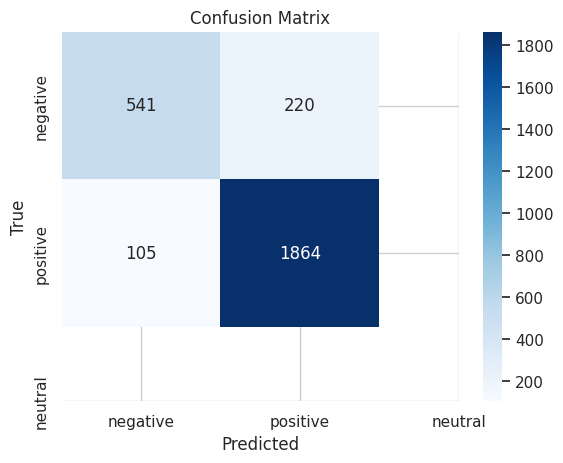

In [ ]:
predict_and_measure3(emotion_detector_model4, validation_DL4, device2)

<ipython-input-114-2e5e2d67bd97>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_labels['emotion_number'] = df_two_labels['label'].map(label_to_int)


For alpha=0.001 and max_features=2000, accuracy is: 0.8216
For alpha=0.001 and max_features=3000, accuracy is: 0.8258
For alpha=0.001 and max_features=4000, accuracy is: 0.8262
For alpha=0.001 and max_features=5000, accuracy is: 0.8267
For alpha=0.001 and max_features=6000, accuracy is: 0.8249
For alpha=0.01 and max_features=2000, accuracy is: 0.8214
For alpha=0.01 and max_features=3000, accuracy is: 0.8262
For alpha=0.01 and max_features=4000, accuracy is: 0.8260
For alpha=0.01 and max_features=5000, accuracy is: 0.8278
For alpha=0.01 and max_features=6000, accuracy is: 0.8258
For alpha=0.1 and max_features=2000, accuracy is: 0.8208
For alpha=0.1 and max_features=3000, accuracy is: 0.8263
For alpha=0.1 and max_features=4000, accuracy is: 0.8282
For alpha=0.1 and max_features=5000, accuracy is: 0.8287
For alpha=0.1 and max_features=6000, accuracy is: 0.8263
For alpha=1 and max_features=2000, accuracy is: 0.8185
For alpha=1 and max_features=3000, accuracy is: 0.8185
For alpha=1 and max_

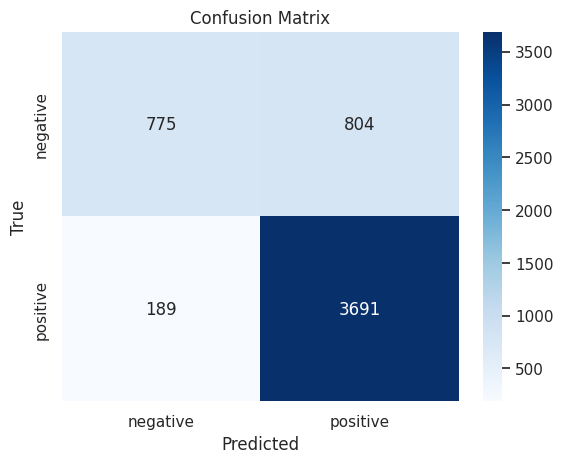

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

unique_labels = df_two_labels['label'].unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
df_two_labels['emotion_number'] = df_two_labels['label'].map(label_to_int)

# Splitting the Data into Train, Validation, and Test sets
X_train, X_test, y_train, y_test = train_test_split(df_two_labels['text'], df_two_labels['emotion_number'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

best_accuracy = 0
best_alpha = None
best_max_features = None
alpha_vals = [10 ** k for k in range(-3, 3)]
max_features_vals = [2000, 3000, 4000, 5000, 6000]

for alpha in alpha_vals:
    for max_features in max_features_vals:
        vec = CountVectorizer(max_features=max_features)
        X_train_vec = vec.fit_transform(X_train)
        X_val_vec = vec.transform(X_val)

        tfidf_transformer = TfidfTransformer()
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
        X_val_tfidf = tfidf_transformer.transform(X_val_vec)

        model = MultinomialNB(alpha=alpha)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        accuracy = accuracy_score(y_val, y_pred)
        print(f"For alpha={alpha} and max_features={max_features}, accuracy is: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_max_features = max_features

# Train the best model on the combined train + validation set
vec = CountVectorizer(max_features=best_max_features)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

print(best_alpha)
print(best_max_features)

best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_tfidf, y_train)
y_pred_test = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
report = classification_report(y_test, y_pred_test)

print('classification_report: \n', report)

labels=['negative','positive']
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Tuning parameters


**These were run in different environments.**

Epoch size

In [ ]:
alphas = [ 0.75, 1, 1.5]
emotion_detector_model4Ep = EmotionDetector(bert_model, class_range=3)
adam_optimizer3Ep = torch.optim.Adam(emotion_detector_model4Ep.parameters(), lr=2e-5)
emotion_detector_model4Ep.to(device2)
focal_lossEp = FocalLoss(alpha=torch.tensor(alphas, device=device2), gamma=2)
epochs = [1,2,3,4,5,10,30]
gammas = [2,3]
emotion_detector_model4.train()

diction = {}

In [ ]:
print("started")
for epoch in epochs:
    for gamma in gammas:
        emotion_detector_model4Ep = EmotionDetector(bert_model, class_range=3)
        adam_optimizer3Ep = torch.optim.Adam(emotion_detector_model4Ep.parameters(), lr=2e-5)
        emotion_detector_model4Ep.to(device2)
        focal_lossEp = FocalLoss(alpha=torch.tensor(alphas, device=device2), gamma=gamma)
        emotion_detector_model4Ep.train()
        print("training with epoch = ",epoch,"gamma = ",gamma)
        loss = train_model(train_DL3, emotion_detector_model4Ep, focal_lossEp, adam_optimizer3Ep, epoch, device2)
        [accuracy,precision,recall,f1] =predict_and_measure2(emotion_detector_model4Ep, validation_DL3, device2) # alpha = 0.75, 1, 1.5 gamma = 2.0
        diction[epoch,gamma] = {"accuracy":accuracy,"precision":precision,"recall":recall,"f1":f1,"loss":loss}

diction

Learning Rate:

In [ ]:
focal_loss2 = FocalLoss(alpha=weights, gamma=2.0)

lr = [5e-5, 3e-5, 2e-5]

num_of_epochs =[2,3,4]

In [ ]:
diction = {}

for lr in lr:
    for epochs in num_of_epochs:

        adam_optimizer_tune = torch.optim.Adam(emotion_detector_model3.parameters(), lr=lr)


        print(f"Training with learning rate: {lr}, Number of epochs: {epochs}")
        train_model(train_DL3, emotion_detector_model3, focal_loss3, adam_optimizer_tune,epochs)
        [accuracy, precision, recall, f1] = predict_and_measure2(emotion_detector_model3, validation_DL3)
        diction[(lr,epochs)] = [accuracy, precision, recall, f1]


Gamma:

In [ ]:
epochs = [1,4]
gammas = [0.5,1,1.5,2,3]
alphas = [0.75, 1, 1.5]
diction = {}

adam_optimizer3 = torch.optim.Adam(emotion_detector_model4.parameters(), lr=2e-5)

for epoch in epochs:
    for gamma in gammas:
        print(f"Training with: Epoch: {epoch}, Gamma: {gamma}")
        focal_loss = FocalLoss(alpha=torch.tensor(alpha, device=device2), gamma=gamma)
        loss = train_model(train_DL3, emotion_detector_model4, focal_loss, adam_optimizer3, epoch, device2)
        [accuracy, precision, recall, f1] = predict_and_measure2(emotion_detector_model4, validation_DL3, device2)
        diction[f"Epoch: {epoch}, Gamma: {gamma}"] = {"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1,"loss":loss}